In [99]:
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import word_tokenize

from collections import defaultdict, Counter
from typing import List, Tuple, Dict

In [100]:
def get_reviews(file_review):
    # Load the CSV file into a DataFrame. Ensure you have the correct path to your CSV file.
    review_csv = pd.read_csv(file_review)

    # Directly select the 'text' and 'stars' columns assuming they exist directly in the CSV
    text_list = review_csv['text'].tolist()  # Convert the 'text' column to a list
    stars_list = review_csv['stars'].astype(int).tolist()  # Convert 'stars' to
    # int and then to list

    # Create a new DataFrame from the lists
    df = pd.DataFrame({
        "text": text_list,
        "stars": stars_list
    })

    return df

In [101]:
df_review = get_reviews("../data/yelp_review_untouched.csv")

In [102]:
df_review.head(10)

,text,stars
0,if you decide to eat here just be aware it is ...,3
1,ive taken a lot of spin classes over the years...,5
2,family diner had the buffet eclectic assortmen...,3
3,wow yummy different delicious our favorite...,5
4,cute interior and owner gave us tour of upcom...,4
5,i am a long term frequent customer of this est...,1
6,loved this tour i grabbed a groupon and the pr...,5
7,amazingly amazing wings and homemade bleu chee...,5
8,this easter instead of going to lopez lake we ...,3
9,had a party of 6 here for hibachi our waitress...,3


In [103]:
df_review["stars"].value_counts(normalize=False)

stars
5    3231626
4    1452918
1    1069558
3     691933
2     544240
Name: count, dtype: int64

In [104]:
def plot_labels(df, title=None):
  ds_labels = df["stars"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(4,3))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Stars")
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".eps")
  plt.show()

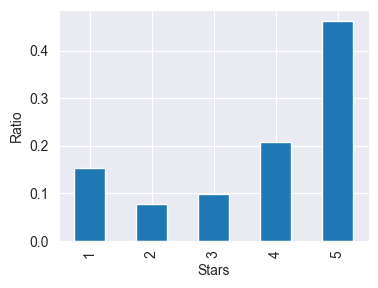

In [105]:
plot_labels(df_review, "stars")

In [106]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test = train_test_split(df_review, test_size=250000,
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=50000,
                                        random_state=42, shuffle=True)

In [107]:
df_train_raw["stars"].value_counts(normalize=False)

stars
5    3000275
4    1348930
1     993387
3     642332
2     505351
Name: count, dtype: int64

In [108]:
from sklearn.utils import resample

def undersample(df, group_size=250000):
  dfs = []

  for label in df["stars"].value_counts().keys():
    df_group = df[df["stars"] == label]
    df_group_undersampled = resample(df_group,
                                     replace=False,
                                     n_samples=group_size,
                                     random_state=0)
    dfs.append(df_group_undersampled)

  return pd.concat(dfs).sample(frac=1, random_state=0)

In [109]:
df_train = undersample(df_train_raw)

In [110]:
num_review = df_review.shape[0]
num_train = df_train.shape[0]
num_dev = df_dev.shape[0]
num_test = df_test.shape[0]

(1250000, 2)


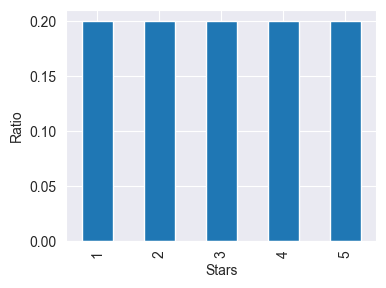

In [111]:
print(df_train.shape)
plot_labels(df_train)

(250000, 2)


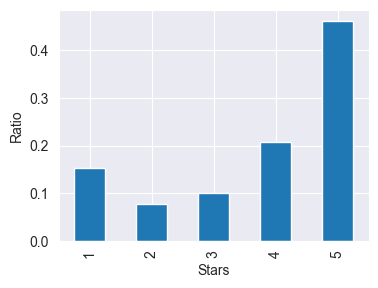

In [112]:
print(df_dev.shape)
plot_labels(df_dev)

(250000, 2)


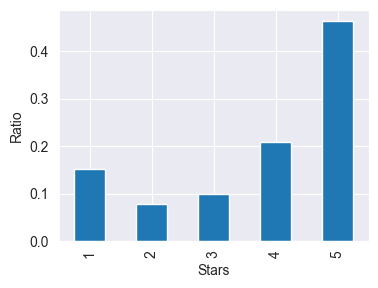

In [113]:
print(df_test.shape)
plot_labels(df_test)

In [114]:
df_train["labels"] = df_train["stars"] - 1
df_dev["labels"] = df_dev["stars"] - 1
df_test["labels"] = df_test["stars"] - 1

In [115]:
df_train.head(10)

,text,stars,labels
5404113,this place is super whatever we waited in line...,3,2
1817189,i would give this restaurant 4stars except for...,3,2
5828525,great food great service went for lunch on a ...,4,3
774735,went to dinner there tonight with three collea...,5,4
6780833,the 2 stars is for the service food is always ...,2,1
2774415,the worst service ever food was disgusting i w...,1,0
844766,i have been to this place twice first was bla...,2,1
4651450,my family loves eddie bulls cookie dough they ...,5,4
1019303,still waiting on my truck that went into the s...,1,0
565233,nash painting was great from start to finish ...,5,4


In [128]:
ds_temp = df_train["text"].iloc[:10].map(lambda text: text.split())
print(df_train["text"].iloc[0], '\n', ds_temp.iloc[0])

this place is super whatever we waited in line for not too long and got sent to the 2nd floor where instead of listening to music we just heard dont forget to tip oh you wanna hear this song thats going to be 20 dollars and other things like that now i 100 get these musicians earn their money from tips but that just really turned me off it made me feel awkward and im sure im not the only one  we left shortly after and enjoyed other bars around where we wanted to tip them for rocking it not demanding it 
 ['this', 'place', 'is', 'super', 'whatever', 'we', 'waited', 'in', 'line', 'for', 'not', 'too', 'long', 'and', 'got', 'sent', 'to', 'the', '2nd', 'floor', 'where', 'instead', 'of', 'listening', 'to', 'music', 'we', 'just', 'heard', 'dont', 'forget', 'to', 'tip', 'oh', 'you', 'wanna', 'hear', 'this', 'song', 'thats', 'going', 'to', 'be', '20', 'dollars', 'and', 'other', 'things', 'like', 'that', 'now', 'i', '100', 'get', 'these', 'musicians', 'earn', 'their', 'money', 'from', 'tips', 'b

In [130]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
  vectorizer = TfidfVectorizer(analyzer='word',
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
  X_train = vectorizer.fit_transform(df_train["text"])
  X_dev = vectorizer.transform(df_dev["text"])
  X_test = vectorizer.transform(df_test["text"])
  y_train = df_train["stars"].tolist()
  y_dev = df_dev["stars"].tolist()
  y_test = df_test["stars"].tolist()

  return X_train, X_dev, X_test, y_train, y_dev, y_test

In [ ]:
X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from simpletransformers.classification import ClassificationModel

In [133]:
def evaluate_bert_model_one(model, df, label="Training", model_name="model"):
  y = df['labels'].tolist()
  y_pred, raw_outputs = model.predict(df['text'].tolist())

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  df_cm = pd.DataFrame(confusion_matrix(y, y_pred, normalize='true'),
                       range(1,6), range(1,6))
  plt.figure(figsize=(6,4))
  ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, square=True)
  ax.set_xlabel('Predicted label')
  ax.set_ylabel('True label')
  plt.savefig(model_name + "_" + label.lower() + ".eps")
  plt.show()
  print()

In [134]:
def evaluate_bert_model(model, model_name="model"):
  evaluate_bert_model_one(model, df_dev, label="Validation", model_name=model_name)
  evaluate_bert_model_one(model, df_test, label="Testing", model_name=model_name)
  # evaluate_bert_model_one(model, df_train, label="Training", model_name=model_name)

In [ ]:
model_bert_base_uncased = \
ClassificationModel('bert',
                    'bert-base-uncased',
                    num_labels=5,
                    use_cuda=False,
                    args={"output_dir": "outputs_bert_base_uncased/",
                          "best_model_dir": "outputs_bert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 200,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": True,
                          "evaluate_during_training_steps": 5000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

In [143]:
model_bert_base_uncased.train_model(df_train, eval_df=df_dev)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/6250 [00:00<?, ?it/s]

KeyboardInterrupt: 